In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [3]:
def zero_pad(X, pad):    
    X_pad=np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),mode='constant',constant_values=0)
    return X_pad

In [11]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 1)
print(x)

[[[[ 1.62434536 -0.61175641]
   [-0.52817175 -1.07296862]
   [ 0.86540763 -2.3015387 ]]

  [[ 1.74481176 -0.7612069 ]
   [ 0.3190391  -0.24937038]
   [ 1.46210794 -2.06014071]]

  [[-0.3224172  -0.38405435]
   [ 1.13376944 -1.09989127]
   [-0.17242821 -0.87785842]]]


 [[[ 0.04221375  0.58281521]
   [-1.10061918  1.14472371]
   [ 0.90159072  0.50249434]]

  [[ 0.90085595 -0.68372786]
   [-0.12289023 -0.93576943]
   [-0.26788808  0.53035547]]

  [[-0.69166075 -0.39675353]
   [-0.6871727  -0.84520564]
   [-0.67124613 -0.0126646 ]]]


 [[[-1.11731035  0.2344157 ]
   [ 1.65980218  0.74204416]
   [-0.19183555 -0.88762896]]

  [[-0.74715829  1.6924546 ]
   [ 0.05080775 -0.63699565]
   [ 0.19091548  2.10025514]]

  [[ 0.12015895  0.61720311]
   [ 0.30017032 -0.35224985]
   [-1.1425182  -0.34934272]]]


 [[[-0.20889423  0.58662319]
   [ 0.83898341  0.93110208]
   [ 0.28558733  0.88514116]]

  [[-0.75439794  1.25286816]
   [ 0.51292982 -0.29809284]
   [ 0.48851815 -0.07557171]]

  [[ 1.13162939

(4, 5, 5, 2)


Text(0.5, 1.0, 'with padding (3,3)')

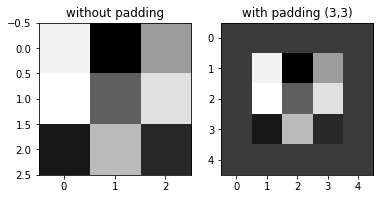

In [12]:

print(x_pad.shape)

fig,ax=plt.subplots(1,2)
ax[0].imshow(x[0,:,:,0],cmap='gray')
ax[0].set_title('without padding')
ax[1].imshow(x_pad[0, :, :, 0],cmap='gray')
ax[1].set_title("with padding (3,3)")

In [30]:
def conv_single_step(a_slice_prev, W, b):
    
    s=np.multiply(a_slice_prev,W)
    Z=np.sum(s)
    Z=Z+float(b)
    return Z

In [31]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


In [32]:
def conv_forward(A_prev, W, b, hparameters):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f,f,n_C_prev,n_C)=W.shape
    
    stride=hparameters['stride']
    pad=hparameters['pad']
    
    n_H = int((n_H_prev-f+2*pad)/stride+1)
    n_W = int((n_W_prev-f+2*pad)/stride+1)
    
    
    Z=np.zeros((m,n_H,n_W,n_C))
    
    A_prev_pad=zero_pad(A_prev,pad)
    for i in range(m):               
        a_prev_pad = A_prev_pad[i]               
        for h in range(n_H):           
            
            vert_start = h*stride
            vert_end = h*stride+f
            
            for w in range(n_W):       
                
                horiz_start = w*stride
                horiz_end = w*stride+f
                
                for c in range(n_C):   
                                        
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    weights = W[...,c]
                    biases = b[...,c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

    
   
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [33]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[0,2,1] =\n", Z[0, 2, 1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


In [35]:
def pool_forward(A_prev, hparameters, mode = "max"):
    
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            
            vert_start = h*stride
            vert_end = h*stride+f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                
                horiz_start = w*stride
                horiz_end = w*stride+f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    return A, cache

In [36]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]

mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


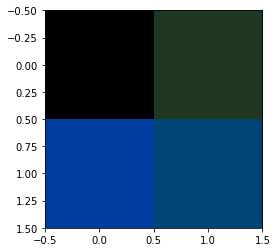

In [41]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])
plt.imshow(A[0],cmap='gray')

In [13]:
0.00047961+0.000049+0.00022201

0.00075062